In [1]:
# Sample to be processed
hpf = '4-24'
study = f'zsf_reference_{hpf}hpf'


In [2]:
# Input/output/resource directories
place = 'nemo'
scratchdir = "/plus/data/@data_scott/common_resources/scDatasets/zsf_reference"
rawdir = f'{scratchdir}/raw_data'
outdir = f'{scratchdir}/project_results'
datadir = f'{scratchdir}/resources'
commonsdir = '/plus/data/@data_scott/common_resources'


In [3]:
# Load libraries
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import graphtools as gt
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
from scipy import io
import anndata as ad
import phate
import magic
import scprep
import sklearn
import meld
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import leidenalg as la
from pygsp import graphs, filters
import time
import natsort

# Package settings
sc.settings.autosave = False
sc.settings.figdir = f'{outdir}/'
np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['animation.embed_limit'] = 1000

In [4]:
# Homemade utility functions
import pyFunctions


In [5]:
# Show loaded libraries
import session_info
session_info.show()

### Load data

In [6]:
# Reload object
sdata = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_{study}_cells_preprocessed.h5ad')
sdata

# Make a list of standard variable of interest (VOIs) to visualise with embeddings
VOIs=['total_counts', 'pct_counts_in_top_50_genes', 'n_genes_by_counts', 'phase', 'study', 'sample', 'Tissue']
VOIs = [*VOIs, *list(sdata.obs['sample'].sort_values().unique())]
VOIs

# Reload graph
G_masked = pickle.load(open(f'{scratchdir}/preprocessed_data/Graph_expression_{study}_cells_all_genes.pkl', "rb" ))
t_param = 'auto'


In [ ]:
# Load preprocessed data
sdata_zebrahub = sc.read_h5ad(f'{commonsdir}/scDatasets/zebrahub2023_sc/preprocessed_data/Anndata_zebrahub_10-24hpf_cells_preprocessed_reference.h5ad')
sdata_zebrahub = sdata_zebrahub[:, ~sdata_zebrahub.var['EnsemblID'].isna()]
sdata_zebrahub.var_names = sdata_zebrahub.var['EnsemblID'].astype('str')
sdata_zebrahub = sdata_zebrahub[:, ~sdata_zebrahub.var.index.duplicated()]
sdata_zebrahub


In [ ]:
# Load preprocessed data
sdata_farrell = sc.read_h5ad(f'{commonsdir}/scDatasets/farrell2023_sc/preprocessed_data/Anndata_farrell_{hpf}hpf_cells_preprocessed_reference.h5ad')
sdata_farrell = sdata_farrell[:, ~sdata_farrell.var['EnsemblID'].isna()]
sdata_farrell.var_names = sdata_farrell.var['EnsemblID'].astype('str')
sdata_farrell = sdata_farrell[:, ~sdata_farrell.var.index.duplicated()]
sdata_farrell


### Concatenate and calculate QC stats

In [ ]:
# Add var and obs info we want to keep to both objects
sdata_zebrahub.obs['sample'] = 'Zebrahub_' + sdata_zebrahub.obs['timepoint'].astype(str)
sdata_zebrahub.obs['tp_prediction'] = sdata_zebrahub.obs['timepoint']
sdata_zebrahub.obs['study'] = "Zebrahub"


In [ ]:
# Add var and obs info we want to keep to both objects
sdata_farrell.obs['tp_prediction'] = sdata_farrell.obs['timepoint']
sdata_farrell.obs['sample'] = sdata_farrell.obs['study'].astype(str) + sdata_farrell.obs['timepoint'].astype(str)


In [ ]:
# Combine both studies (note only matches genes that share emsembl ID)
sdata = ad.concat([sdata_zebrahub, sdata_farrell], index_unique="_", merge="same", join='inner')
sdata.obs['merge'] = sdata.obs.index.astype(str).str[-1]
sdata.obs['merge'] = sdata.obs['merge'].replace({'0': 'zebrahub', '1': 'farrell'})

# # Assigns individual samples within both studies (note order matters)
# sdata.obs['batch'] = np.where(sdata.obs.index.str.contains("DS5b"), "DS5b", 
#                               np.where(sdata.obs.index.str.contains("DS5"), "DS5", "Multiome"))

del sdata_farrell

# del sdata3
print(sdata)
sdata.obs['sample'].value_counts()

In [ ]:
# Create obs for individual timepoints
for tp in list(sdata.obs["sample"].sort_values().unique()):
    sdata.obs[tp] = (sdata.obs["sample"] == tp)
    sdata.obs[tp] = sdata.obs[tp].replace({True: tp, False: np.nan})
    sdata.obs[f'Tissue_{tp}'] = sdata.obs['Tissue'].mask(~sdata.obs["sample"].isin([tp]))
    sdata.obs[f'Subtissue_{tp}'] = sdata.obs['Subtissue'].mask(~sdata.obs["sample"].isin([tp]))

sdata.obs.columns


In [ ]:
# Create integer valued HPF
sdata.obs['HPF'] = sdata.obs['timepoint'].str.removesuffix('hpf').astype(int)


In [ ]:
# Create Study only labels
sdata.obs['Zebrahub_sample'] = sdata.obs['sample'].mask(~(sdata.obs["study"] == 'Zebrahub'))
sdata.obs['Shier_sample'] = sdata.obs['sample'].mask(~(sdata.obs["study"] == 'Shier'))
sdata.obs['Farrell_sample'] = sdata.obs['sample'].mask(~(sdata.obs["study"] == 'Farrell'))


In [ ]:
# Restore var info from zebrahub
sdata.var = sdata_zebrahub.var.loc[sdata.var.index]
sdata.var_names = sdata.var.gene_symbol
del sdata_zebrahub
sdata

In [ ]:
# Calculate QC stats
sc.pp.calculate_qc_metrics(sdata, inplace=True, layer='X_preNorm')


In [ ]:
# Plot coloured by stage
sdata.obs['log10_total_counts'] = np.log10(sdata.obs["total_counts"])
sc.pl.scatter(sdata, x='log10_total_counts', y='n_genes_by_counts', color="sample")


In [ ]:
# Plot percent of counts in top 50 genes
pct_counts_in_top_50_genes_threshold = 45
scprep.plot.histogram(sdata.obs["pct_counts_in_top_50_genes"], cutoff=pct_counts_in_top_50_genes_threshold, title='Counts in top 50 genes (%)')


In [ ]:
# View top expressed genes in cells where few genes dominate
sc.pl.highest_expr_genes(sdata[sdata.obs.pct_counts_in_top_50_genes > pct_counts_in_top_50_genes_threshold], n_top=20)


In [ ]:
# View total number of genes per cell
min_cells = 10
scprep.plot.histogram(sdata[:,sdata.var.n_cells_by_counts < 100].var["n_cells_by_counts"], cutoff=min_cells)


In [ ]:
# Filter to genes expressed in at least 10 cells
# sc.pp.filter_genes(sdata, min_cells=10)


### Normalise transform score cell cycle

In [ ]:
## Counts are already normalised in each object
# Normalise by library size and square-root transform
# sdata = sdata.copy()
# sdata.X = scipy.sparse.csr_matrix(scprep.normalize.library_size_normalize(sdata.X.toarray())).sqrt()
# sdata

### Dimensionality reduction, graph and embed


In [ ]:
# Make a list of standard variable of interest (VOIs) to visualise with embeddings
VOIs=['total_counts', 'pct_counts_in_top_50_genes', 'n_genes_by_counts', 'phase', 'study', 'sample', 'Tissue']
VOIs = [*VOIs, *list(sdata.obs['sample'].sort_values().unique())]
VOIs

In [ ]:
# Select highly variable genes from any batch
HVG_all = []
for batch in sdata.obs['study'].unique():
    normalised, HVG_vars = scprep.select.highly_variable_genes(sdata[sdata.obs['study'] == batch].X.toarray(), sdata[sdata.obs['study'] == batch].var.index, cutoff=None, percentile=80)
    HVG_all.extend(HVG_vars)
    sdata.var[f'highly_variable_{batch}'] = sdata.var.index.isin(HVG_vars)
    del normalised
    print(f"Unique HVGs after {batch} {len(np.unique(np.array(HVG_all)))}")
    
sdata.var['highly_variable'] = sdata.var.index.isin(HVG_all)


In [ ]:
# # Calculate the number of significant PCs based on marchenko.pastur max (heuristic)
# from sklearn.decomposition import PCA

# pca = PCA(n_components=100, random_state=42)
# X_transformed = pca.fit_transform(sdata.layers["X_scaled"].toarray())
# eigenvalues = pca.explained_variance_

# M = np.shape(sdata.layers["X_scaled"].toarray())[1]
# N = np.shape(sdata.layers["X_scaled"].toarray())[0]
# MPmax = (1 + np.sqrt(M/N))**2

# npcs = sum(eigenvalues > MPmax)
# npcs


In [ ]:
# Scale within each batch/sample (makes a big difference here. Very useful as we can assume they are the same ie replicates of same timepoint)
sdata.raw = sdata
for batch in sdata.obs['merge'].unique():
    # Subset to batch
    tmp = sdata[sdata.obs['merge'] == batch, sdata.var['highly_variable']]
    # Scale within each batch
    sc.pp.scale(tmp, copy = False)
    if batch == sdata.obs['merge'].unique()[0]:
        zscores = tmp
    else:
        zscores = ad.concat([zscores, tmp])

zscores = zscores[sdata.obs.index,:].X
del tmp


In [ ]:
# Calculate the number of significant PCs based on marchenko.pastur max (heuristic)
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_transformed = pca.fit_transform(zscores)
eigenvalues = pca.explained_variance_

M = np.shape(zscores)[1]
N = np.shape(zscores)[0]
MPmax = (1 + np.sqrt(M/N))**2

npcs = sum(eigenvalues > MPmax)
npcs

del zscores

In [ ]:
# Save PCA operator
pickle.dump(pca, open(f'{scratchdir}/preprocessed_data/PCA_op_expression_{study}_cells_all_genes.pkl', "wb"))


In [ ]:
# Scree plot of eigenvalues
scprep.plot.scree_plot(eigenvalues, cumulative=False)


In [ ]:
# Add to sdata subsetting to significant PCs
sdata.obsm["X_pca"] = X_transformed[0:,range(npcs)]


In [ ]:
# Plot PC1 PC2  using HVGs with VOIs
sc.pl.embedding(sdata, basis='X_pca', color=VOIs, color_map='magma', save=f'.QC_{study}_PC1PC2_PCs_all_genes.png')


In [ ]:
# Plot PC2 PC3  using HVGs with VOIs
sc.pl.embedding(sdata, basis='X_pca', color=VOIs, dimensions=(1,2), color_map='magma', save=f'.QC_{study}_PC2PC3_PCs_all_genes.png')


In [ ]:
# Export gene PCs
pc_loadings = pd.DataFrame(pca.components_, columns=sdata[:, sdata.var['highly_variable']].var.index, index=["PC" + str(i) for i in range(1,100 + 1)])


In [ ]:
# Plot genes with the strongest effect on PC1
top_loadings = list(pc_loadings.transpose().PC1.abs().sort_values(ascending=False).head(20).index)
sc.pl.embedding(sdata, basis='X_pca', color=top_loadings, color_map='magma', save=f'.QC_{study}_PC1_top_genes.png')


In [ ]:
# Make initial cellwise graph with all genes
G = gt.Graph(sdata.obsm["X_pca"], n_pca=None, random_state=42, n_jobs=-2, knn=10, sample_idx=sdata.obs["sample"], verbose=True)


In [ ]:
# Save graph
G.to_pickle(f'{scratchdir}/preprocessed_data/Graph_expression_{study}_cells_all_genes_unfiltered.pkl') # all genes

In [ ]:
# Embed with PHATE (auto t=6)
t_param = 'auto'
# t_param = 12
phate_op = phate.PHATE(random_state=0, t=t_param, n_jobs=-2)
data_phate = phate_op.fit_transform(G)
sdata.obsm["X_phate"] = data_phate[0:,0:]


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


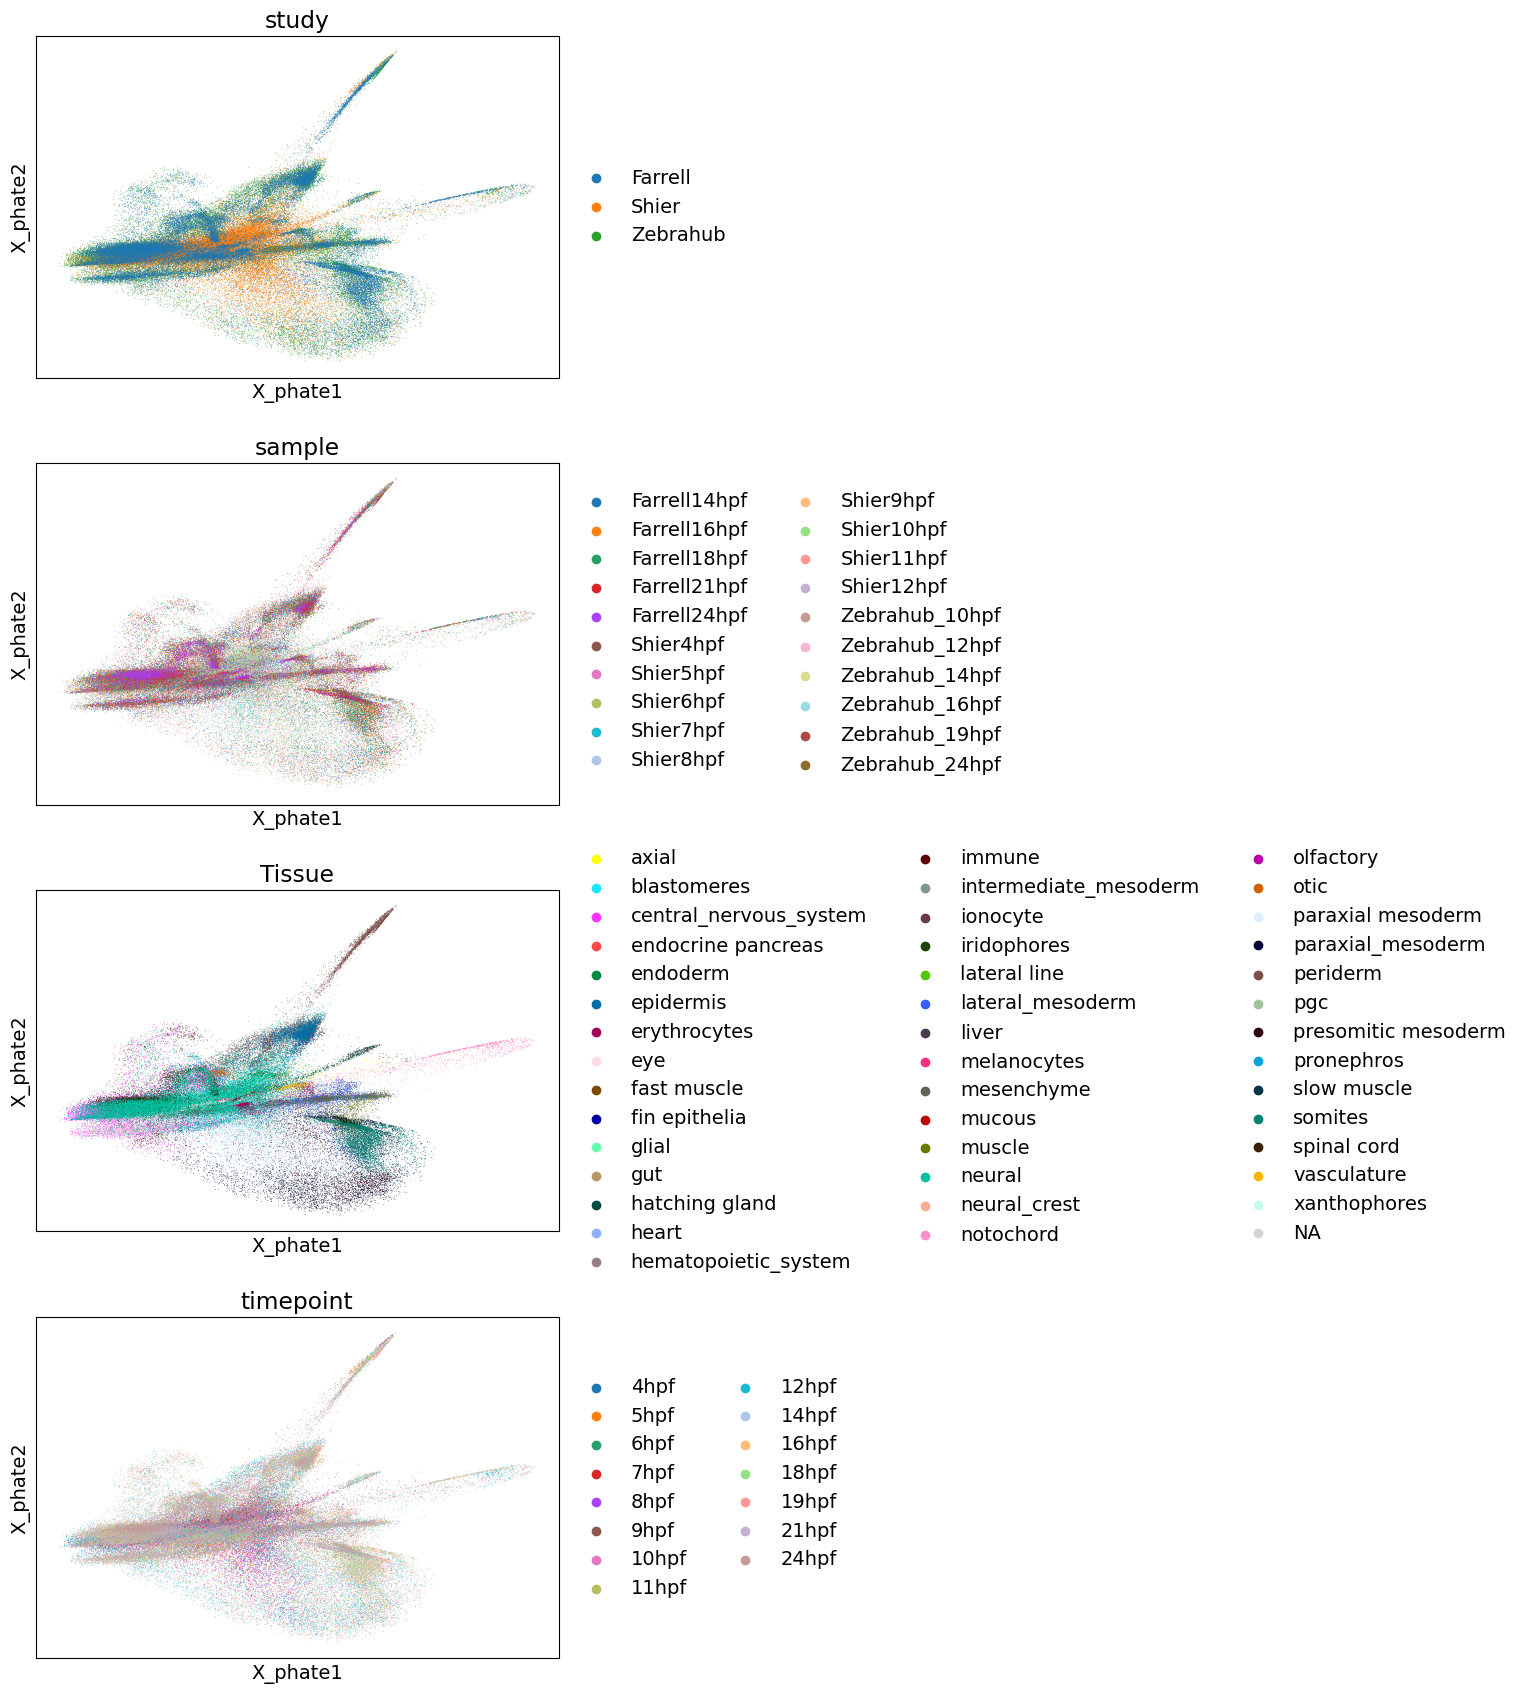

In [7]:
# Draw phate plot using all genes
sc.pl.embedding(sdata, basis='X_phate', sort_order=True, vmin=0, color=['study', 'sample', 'Tissue', 'timepoint'], use_raw = False, color_map='magma', ncols=1)


In [ ]:
# Draw phate plot using all genes
sc.pl.embedding(sdata, basis='X_phate', sort_order=True, vmin=0, color=VOIs, use_raw = False, color_map='magma', save=f'.QC_{study}_farrell_coembedding_PHATE_all_genes.png')


### Make adjacency to only include connections between adjacent timepoints


In [ ]:
# # Reload object
# sdata = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_{study}_cells_preprocessed.h5ad')
# sdata

In [ ]:
# # Reload graph
# G = pickle.load(open(f'{scratchdir}/preprocessed_data/Graph_expression_{study}_cells_all_genes_unfiltered.pkl', "rb" ))


In [ ]:
# Converts classes to indices (first converted to int to ensure ascending order)
_, tp = np.unique(sdata.obs['timepoint'].str.removesuffix('hpf').astype(int).to_numpy(), return_inverse=True)
tp = np.reshape(tp, (1, tp.shape[0]))

# Parameters for mask
threshold = 0.8

# Creates a mask to only include connections between sequential timepoints unless above a certain value (in chuncks)
stcon=0
totcon=0

for bin in pyFunctions.utils.batched(sdata.shape[0], 10000):

    # Creates a mask for strong connections
    tmp_mask = G.K[bin]
    tmp_mask.data[tmp_mask.data >= threshold] = 1
    tmp_mask = tmp_mask.astype(int)
    stcon+=tmp_mask.sum()

    # Creates mask for just sequenctial timepoints
    tmp_mask = scipy.sparse.csr_matrix(np.abs(tp[:,bin].T - tp) <= 1, dtype=int).maximum(tmp_mask)
    totcon+=tmp_mask.sum()

    # Mask connections
    tmp_mask = G.K[bin].multiply(tmp_mask)

    # Stack chunks
    if list(bin)[0] != 0:
        tp_mask = scipy.sparse.vstack([tp_mask, tmp_mask])
    else:
        tp_mask = tmp_mask

    del tmp_mask
    print(np.shape(tp_mask))

# Create graph from masked adjacency
G_masked = gt.Graph(tp_mask, precomputed='adjacency', n_jobs=-2, random_state=42, knn=G.knn)
G_masked.data = sdata.X

# print(f'Number of connections >= {threshold} between non-adjacent timepoints: {totcon - (totcon - stcon)}')


In [ ]:
# Save graph
G_masked.to_pickle(f'{scratchdir}/preprocessed_data/Graph_expression_{study}_cells_all_genes.pkl') # all genes


In [ ]:
# Embed with PHATE (auto t=32)
t_param = 'auto'
# t_param = 40
phate_op = phate.PHATE(random_state=0, t=t_param, n_jobs=-2)
data_phate = phate_op.fit_transform(G_masked)
sdata.obsm["X_phate_masked"] = data_phate[0:,0:]


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


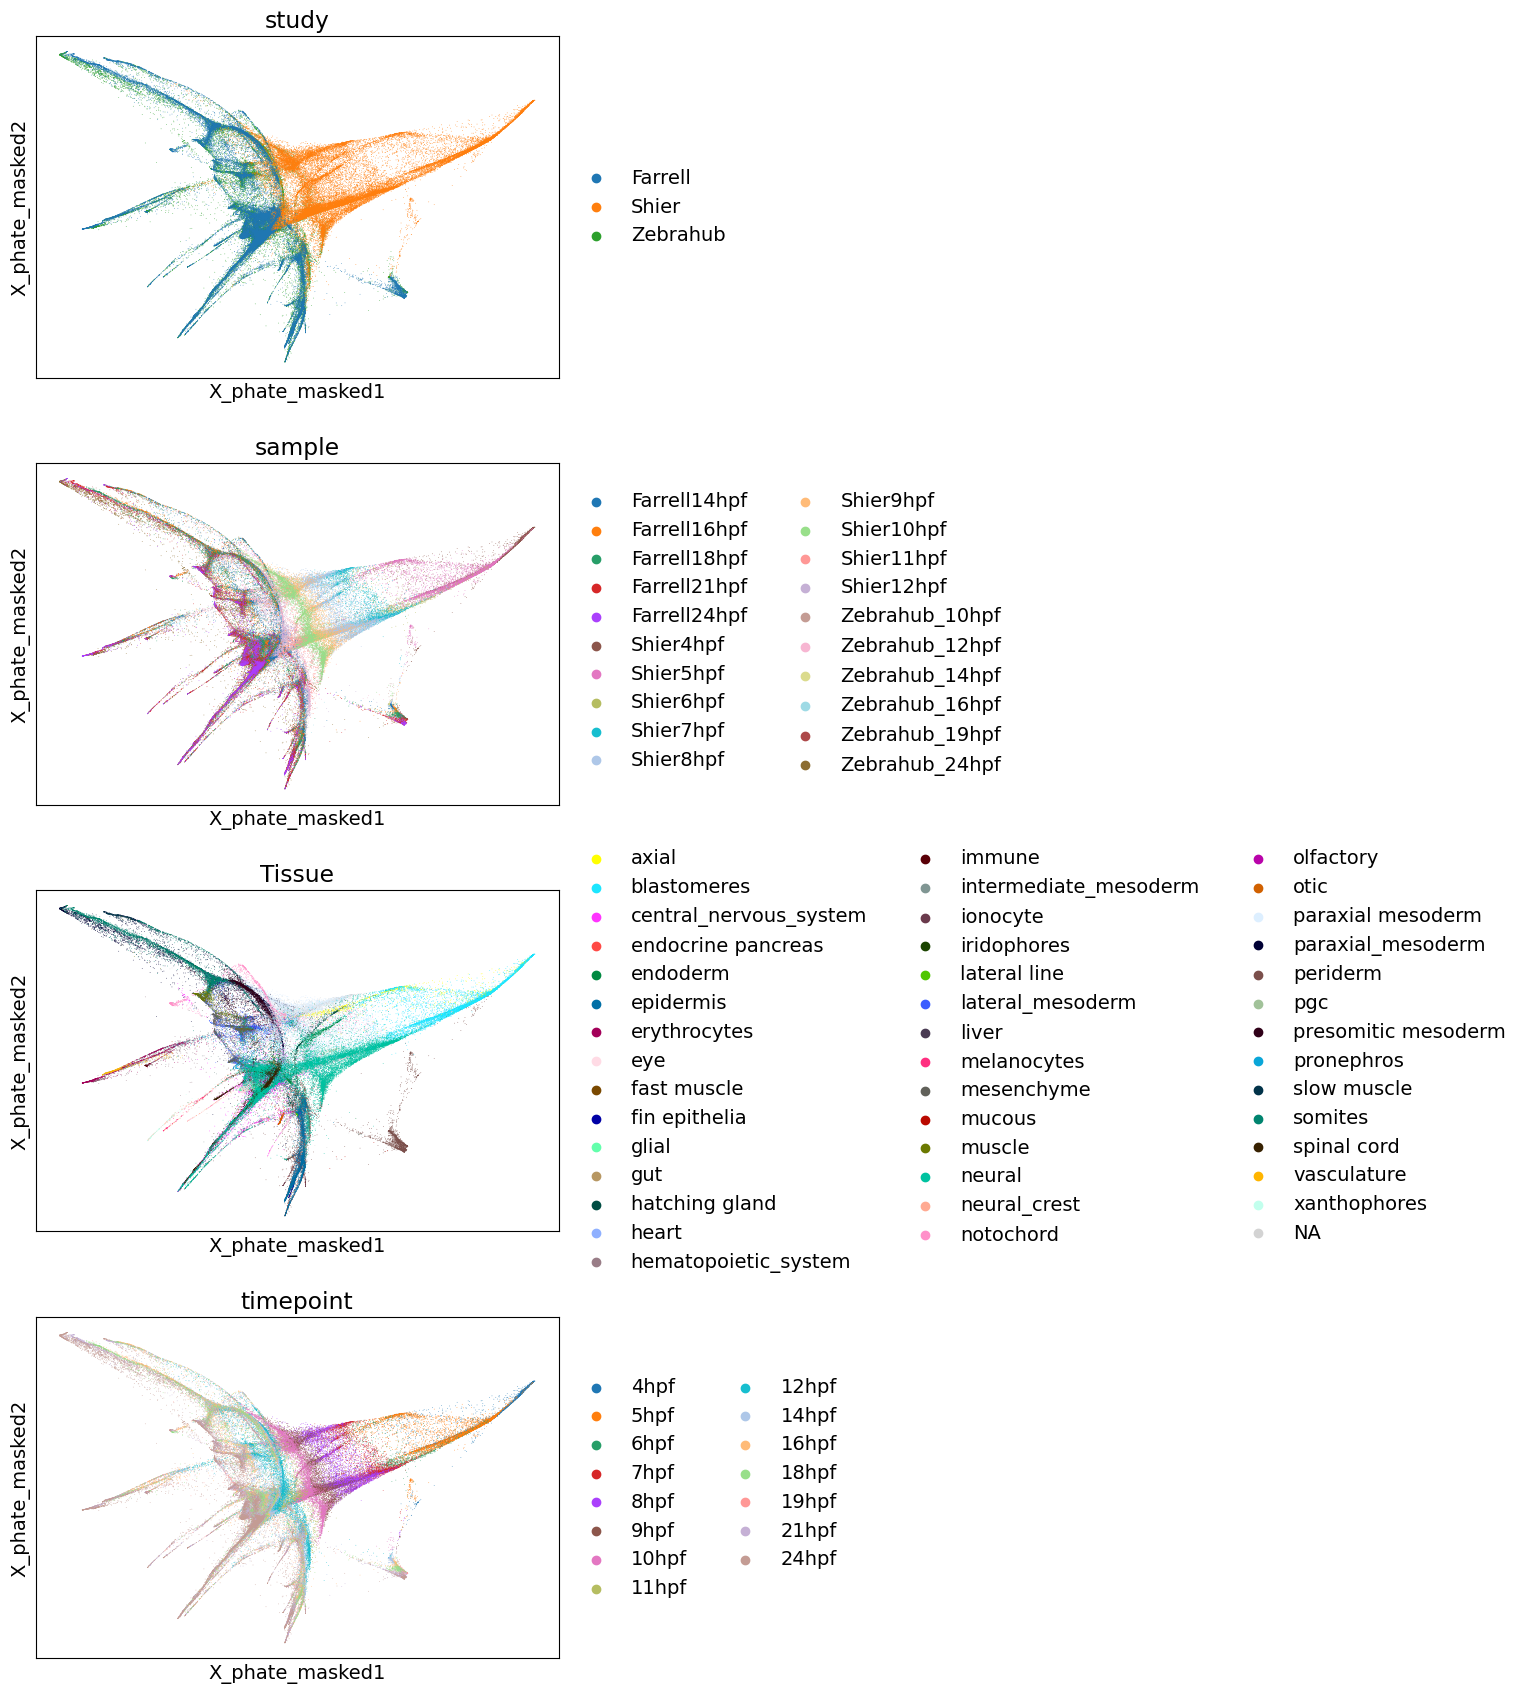

In [8]:
# Draw phate plot using all genes
sc.pl.embedding(sdata, basis='X_phate_masked', sort_order=True, vmin=0, color=['study', 'sample', 'Tissue', 'timepoint'], use_raw = False, color_map='magma', ncols=1)


In [ ]:
# Draw phate plot using all genes
sc.pl.embedding(sdata, basis='X_phate_masked', sort_order=True, vmin=0, color=list(sdata.obs['sample'].sort_values().unique()), use_raw = False, color_map='magma', ncols=3)

COIs = sdata.obs.columns[sdata.obs.columns.str.startswith("Tissue")]
sc.pl.embedding(sdata, basis='X_phate_masked', sort_order=True, vmin=0, color=COIs, use_raw = False, color_map='magma', ncols=3)


In [ ]:
pickle.dump(phate_op, open(f'{scratchdir}/preprocessed_data/PHATE_op_expression_{study}_cells_all_genes.pkl', "wb"))


In [ ]:
# Embed with PHATE (auto t=33)
phate_op = phate.PHATE(random_state=0, t=t_param, n_jobs=-2, n_components=3)
data_phate = phate_op.fit_transform(G_masked)
sdata.obsm["X_phate_masked_3d"] = data_phate[0:,0:]


In [ ]:
# plt = scprep.plot.scatter3d(sdata.obsm['X_phate_masked_3d'],
#                       alpha=0.3, c=sdata.obs['HPF'], figsize=(7, 7), legend=True,
#                       fontsize=6, cmap='magma', ticks=False, azim=235, dpi=300)
# plt.axis('off')

In [ ]:
# plt = scprep.plot.scatter3d(sdata.obsm['X_phate_masked_3d'],
#                       alpha=0.3, c=sdata.obs['HPF'], figsize=(7, 7), legend=True,
#                       fontsize=6, cmap='magma', ticks=False, azim=240, dpi=300)
# plt.axis('off')


In [ ]:
# Visualise 3d embedding with Timepoint
scprep.plot.rotate_scatter3d(sdata.obsm['X_phate_masked_3d'], alpha=0.3, c=sdata.obs['HPF'], figsize=(8, 8), legend_loc='upper right', fontsize=6, cmap='magma', filename = f"{outdir}/{study}_PHATE_HVG_genes_masked_Timepoint.gif")


In [ ]:
# Get Euclidean distances
sc.pp.neighbors(sdata, use_rep='X_pca', knn=G_masked.knn)

In [ ]:
# Replace affinties with our kernel matrix (changing diagonal to zeros)
tmp = G_masked.kernel
tmp.setdiag(0)
sdata.obsp['connectivities'] = tmp.astype('float32')
del tmp

In [ ]:
# Calculate UMAP
sc.tl.umap(sdata, random_state=42)
sdata.obsm['X_umap_masked'] = sdata.obsm['X_umap']
del sdata.obsp['connectivities']

In [ ]:
# Plot UMAP
sc.pl.embedding(sdata, basis='X_umap_masked', sort_order=True, vmin=0, color=VOIs, use_raw = False, color_map='magma', save=f'.QC_{study}_UMAP.png')


### Cluster based on masked graph

In [ ]:
def leidenGT(df, G, res=1):
    partition = la.find_partition(G.to_igraph(), la.RBConfigurationVertexPartition, weights="weight", resolution_parameter=res, n_iterations=-1)
    df[f"Leiden_res_{res}"] = np.array(partition.membership)
    df[f"Leiden_res_{res}"] = df[f"Leiden_res_{res}"].astype("category")
    print(df[f"Leiden_res_{res}"].value_counts())
    return df

In [ ]:
# Find cluster of cells based on original cell x cell graph
from joblib import Parallel, delayed 

clusters = pd.DataFrame(index=sdata.obs.index)
# cell_resolution = [0.4, 0.7, 1, 1.5, 2, 3, 4, 5 ,6 ,7 ,8 ,9 ,10]
cell_resolution = [5,6,7,8,9,10]

with Parallel(n_jobs=len(cell_resolution)) as p:
    results = p(delayed(leidenGT)(clusters, G_masked, res=i) 
              for i in cell_resolution)

# sdata.obs = pd.concat([sdata.obs.loc[:,~sdata.obs.columns.str.contains("Leiden_")], *results], axis=1)
sdata.obs = pd.concat([sdata.obs, *results], axis=1)


In [ ]:
# Plot clustering results
sc.pl.embedding(sdata, basis='X_phate_masked', color=sdata.obs.columns[sdata.obs.columns.str.contains("Leiden_").tolist()], add_outline=True, legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, save=f'.QC_{study}_PHATE_leiden_multi_resolutions.png')
sc.pl.embedding(sdata, basis='X_umap_masked', color=sdata.obs.columns[sdata.obs.columns.str.contains("Leiden_").tolist()], add_outline=True, legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, save=f'.QC_{study}_UMAP_leiden_multi_resolutions.png')


In [ ]:
# Save annotated sdata object
sdata.write(f'{scratchdir}/preprocessed_data/Anndata_{study}_cells_preprocessed.h5ad')


### Find DEG and DDTF per cluster

In [18]:
clusterings = sdata.obs.columns[sdata.obs.columns.str.contains("Leiden_").tolist()].to_list()
clusterings

['Leiden_res_0.4',
 'Leiden_res_0.7',
 'Leiden_res_1',
 'Leiden_res_1.5',
 'Leiden_res_2',
 'Leiden_res_3',
 'Leiden_res_4',
 'Leiden_res_5',
 'Leiden_res_6',
 'Leiden_res_7',
 'Leiden_res_8',
 'Leiden_res_9',
 'Leiden_res_10']

In [ ]:
# # Visualise 3d embedding with Timepoint
# for res in clusterings:
#     scprep.plot.rotate_scatter3d(sdata.obsm['X_phate_masked_3d'], alpha=0.3, c=sdata.obs[res], figsize=(8, 8), legend_loc='upper right', fontsize=6, cmap='magma', filename = f"{outdir}/clusters/{study}_PHATE_HVG_genes_masked_{res}.gif")


In [ ]:
# Get differentially detected TFs
from joblib import Parallel, delayed
from pyFunctions.utils import OR

# Get differentially expressed TFs
for res in clusterings:

    DDTFs = Parallel(n_jobs=3, prefer="threads")(delayed(OR)(sdata[:,sdata.var['AnySpecies_TFs']], cluster_col = res, cluster = st, eps = 1e-7, correction = 'fdr_bh', return_significant = False)
             for st in sdata.obs[res].cat.categories.to_list())
    
    DETFs = scprep.stats.differential_expression_by_cluster(
        sdata[:,sdata.var['AnySpecies_TFs']].X,
        sdata.obs[res],
        measure='difference',
        direction='up',
        n_jobs=-2,
        gene_names=sdata[:,sdata.var['AnySpecies_TFs']].var.index)
    
     # Combine results and save
    for clust in range(len(DETFs)):
        DDTFs[clust]['OR_rank'] = list(range(1, DDTFs[clust].shape[0]+1))
        DETFs[clust].rename(columns={'rank':'lfc_rank'}, inplace=True)
        DTFs = pd.concat([DDTFs[clust], DETFs[clust]], axis=1)
        DTFs['combined_rank'] = DTFs['OR_rank'] + DTFs['lfc_rank'] 
        DTFs.sort_values('combined_rank').to_csv(f'{outdir}/clusters/DTFs_{res}_cluster_{clust}.csv')
    
    del DDTFs
    del DETFs


In [19]:
# Get differentially expressed genes
for res in clusterings:

    # DDGs = Parallel(n_jobs=3, prefer="threads")(delayed(OR)(sdata, cluster_col = res, cluster = st, eps = 1e-7, correction = 'fdr_bh', return_significant = False)
    #          for st in sdata.obs[res].cat.categories.to_list())
    
    DEGs = scprep.stats.differential_expression_by_cluster(
        sdata.X,
        sdata.obs[res],
        measure='difference',
        direction='up',
        n_jobs=-2,
        gene_names=sdata.var.index)
    
     # Combine results and save
    for clust in range(len(DEGs)):
        DEGs[clust].rename(columns={'rank':'lfc_rank'}, inplace=True)
        DEGs[clust].sort_values('lfc_rank').to_csv(f'{outdir}/clusters/DGs_{res}_cluster_{clust}.csv')
    
    del DEGs


In [ ]:
# # Get differentially expressed genes
# DEGs = scprep.stats.differential_expression_by_cluster(
#     sdata.X,
#     sdata.obs['Leiden_res_0.4'],
#     measure='difference',
#     direction='up',
#     n_jobs=-2,
#     gene_names=sdata.var.index
#     )
    

In [ ]:
# # Get differentially detected genes
# from joblib import Parallel, delayed
# from pyFunctions.utils import OR

# DDGs = Parallel(n_jobs=3, prefer="threads")(delayed(OR)(sdata[:,sdata.var['AnySpecies_TFs']], cluster_col = 'Leiden_res_0.4', cluster = st, eps = 1e-7, correction = 'fdr_bh', return_significant = False)
#              for st in sdata.obs['Leiden_res_0.4'].cat.categories.to_list())
# DDGs


In [ ]:
# del DDGs

In [81]:
counts = sdata.obs.groupby([res, 'timepoint']).size().reset_index(name='count')
counts = counts.pivot(index=res, columns='timepoint', values='count').apply(lambda x:100 * x / float(x.sum()), axis=0)
counts.astype(int).style.background_gradient(cmap ='YlGnBu', axis=1)\
        .set_properties(**{'font-size': '10px'})

timepoint,4hpf,5hpf,6hpf,7hpf,8hpf,9hpf,10hpf,11hpf,12hpf,14hpf,16hpf,18hpf,19hpf,21hpf,24hpf
Leiden_res_0.4,,,,,,,,,,,,,,,
0,0,0,13,65,68,67,66,48,14,6,4,5,0,2,4
1,0,0,0,0,0,0,0,7,23,23,24,20,40,29,24
2,0,0,0,0,2,12,17,14,19,19,16,16,5,5,6
3,97,97,80,22,14,2,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,6,11,14,13,11,14,11,9
5,0,0,0,0,0,0,0,2,8,9,9,15,8,14,12
6,0,0,0,1,4,8,9,9,8,6,6,3,6,6,8
7,0,0,0,0,0,0,0,1,4,6,6,5,7,7,7
8,0,0,0,0,0,0,0,0,0,1,3,8,1,7,7


In [83]:
# Plot proportion of each timepoint in each cluster at each resolution
for res in clusterings:
    counts = sdata.obs.groupby([res, 'timepoint']).size().reset_index(name='count')
    counts = counts.pivot(index=res, columns='timepoint', values='count').apply(lambda x:100 * x / float(x.sum()), axis=0)
    counts.to_csv(f'{outdir}/clusters/Normalised_timepoint_proportions_{res}.csv')
    counts.astype(int).style.background_gradient(cmap ='YlGnBu', axis=1)\
            .set_properties(**{'font-size': '10px'})


<Axes: xlabel='Leiden_res_2'>

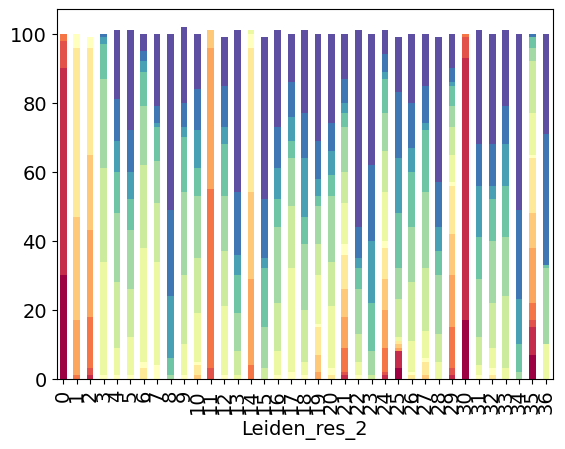

In [71]:
# # Plot proportion of each timepoint in each cluster at each resolution
# counts = sdata.obs.groupby(['Leiden_res_2', 'timepoint']).size().reset_index(name='count')
# counts = counts.pivot(index='Leiden_res_2', columns='timepoint', values='count').apply(lambda x:100 * x / float(x.sum()), axis=1).round(0)
# counts.plot(kind='bar', stacked=True, cmap='Spectral', legend=False)

### Smooth counts based on graph

In [ ]:
# # Reload object
# sdata = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_{study}_cells_preprocessed.h5ad')
# sdata

In [ ]:
# # Reload graph
# G_masked = pickle.load(open(f'{scratchdir}/preprocessed_data/Graph_expression_{study}_cells_all_genes.pkl', "rb" ))


In [ ]:
# Calculate MAGIC smoothed counts of genes (rounding increases sparsity)
from joblib import Parallel, delayed

def batchMAGIC(adata, chunk, G, magic_op, rounding=2):
    print(adata.var.index[list(chunk)].to_list()[:10])
    data_magic = scipy.sparse.csr_matrix(np.round(magic_op.transform(genes=list(chunk)), decimals=rounding))
    return data_magic

magic_op = magic.MAGIC(n_jobs=1, random_state=42, t=3, solver='exact').fit(sdata.X, graph=G_masked)

with Parallel(n_jobs=10, prefer="threads", verbose=10) as p:
    data_magic = p(delayed(batchMAGIC)(
        sdata,
        chunk,
        G_masked,
        magic_op,
        rounding=2
    ) for chunk in pyFunctions.utils.batched(sdata.shape[1], 1000))


data_magic = scipy.sparse.hstack(data_magic)

io.mmwrite(f'{scratchdir}/preprocessed_data/MAGIC_expression_{study}_cells_preprocessed.mtx', data_magic)


### Save progress (compatible with python and R)

In [ ]:
del sdata.layers['X_magic']

In [ ]:
# Save annotated sdata object
sdata.write(f'{scratchdir}/preprocessed_data/Anndata_{study}_cells_preprocessed.h5ad')


In [ ]:
# Save PCs and embeddings
pd.DataFrame(sdata.obsm["X_phate_masked"], index=sdata.obs.index, columns=['PHATE1', 'PHATE2']).to_csv(f'{scratchdir}/preprocessed_data/Obsm_PHATE_expression_{study}_cells_preprocessed.csv')
pd.DataFrame(sdata.obsm["X_phate_masked_3d"], index=sdata.obs.index, columns=['PHATE1', 'PHATE2', 'PHATE3']).to_csv(f'{scratchdir}/preprocessed_data/Obsm_PHATE3d_expression_{study}_cells_preprocessed.csv')
pd.DataFrame(sdata.obsm["X_umap_masked"], index=sdata.obs.index, columns=['UMAP1', 'UMAP2']).to_csv(f'{scratchdir}/preprocessed_data/Obsm_UMAP_expression_{study}_cells_preprocessed.csv')
pd.DataFrame(sdata.obsm["X_pca"], index=sdata.obs.index, columns=["PC" + str(i) for i in range(1,np.shape(sdata.obsm["X_pca"])[1] + 1)]).to_csv(f'{scratchdir}/preprocessed_data/Obsm_PCs_expression_{study}_cells_preprocessed.csv')


In [ ]:
raise SystemExit("Relaxing...")